In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from pathlib import Path

In [2]:
data_dir = Path("/home/beatriz/Documents/2. Documents/2. USP/4. TCC/literary-knowledge-network/data")
work_path = data_dir / "processed/enriched/work_final.csv"
comm_path = data_dir / "output/communities/work_communities.csv"

works = pd.read_csv(work_path)
communities = pd.read_csv(comm_path)
df = communities.merge(works, on="work_id", how="left")

language_candidates = [
    "inferred_language_code",
    "original_language_id",
    "language_code",
    "best_book_language_code",
]
selected_language_column = next((col for col in language_candidates if col in df.columns), None)
if selected_language_column is None:
    raise KeyError("No language-like column found in the merged dataframe.")

LANGUAGE_FIELD = "language_code_for_analysis"
df[LANGUAGE_FIELD] = df[selected_language_column]

print(f"Loaded {len(df)} works with {df['cluster_id'].nunique()} detected communities.")
print(f"Using '{selected_language_column}' as the language signal for cluster analyses.")


Loaded 2470 works with 86 detected communities.
Using 'original_language_id' as the language signal for cluster analyses.


# Language Purity by Community

In [3]:
def language_purity(group):
    values = group[LANGUAGE_FIELD].dropna()
    if values.empty:
        return np.nan
    lang_counts = values.value_counts(normalize=True)
    return lang_counts.iloc[0]

lang_purity = (
    df.groupby("cluster_id")
      .apply(language_purity)
      .reset_index(name="language_purity")
)

# Determine dominant language and count per cluster
dominant_lang = (
    df.groupby("cluster_id")[LANGUAGE_FIELD]
      .agg(lambda x: x.dropna().value_counts().idxmax() if x.dropna().size else np.nan)
      .reset_index(name="dominant_language")
)
lang_summary = df.groupby("cluster_id")["work_id"].count().reset_index(name="num_works")
lang_summary = lang_summary.merge(lang_purity, on="cluster_id").merge(dominant_lang, on="cluster_id")

# Save table
out_dir = data_dir / "output/figures"
out_dir.mkdir(parents=True, exist_ok=True)
lang_summary.to_csv(out_dir / "language_purity_by_cluster.csv", index=False)


/tmp/ipykernel_89181/2324006463.py:10: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(language_purity)


# Plot Language Purity Distribution

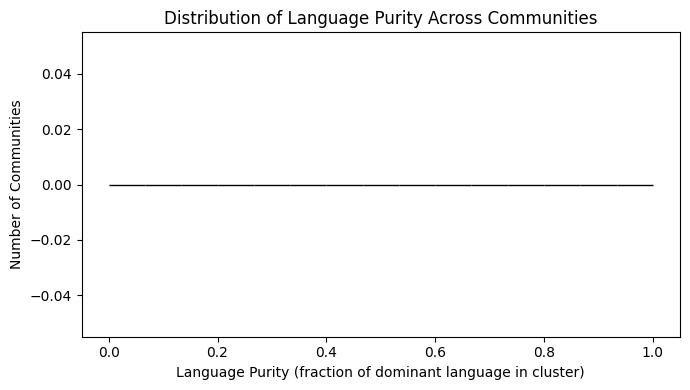

In [4]:
# --------------------------------------------------------------------
# 3. Plot: Language Purity Distribution
# --------------------------------------------------------------------
plt.figure(figsize=(7,4))
sns.histplot(data=lang_summary, x="language_purity", bins=15, color="gray", edgecolor="black")
plt.xlabel("Language Purity (fraction of dominant language in cluster)")
plt.ylabel("Number of Communities")
plt.title("Distribution of Language Purity Across Communities")
plt.tight_layout()
plt.savefig(out_dir / "language_purity_distribution.png", dpi=300)
plt.show()



# Language Assortativity

In [5]:
# Build subgraph from df (only connected works)
G = nx.Graph()
for _, row in df.iterrows():
    G.add_node(row["work_id"], language=row[LANGUAGE_FIELD])
# NOTE: optional: add edges if you have an edge list csv; here we skip edge import

# Compute language assortativity
if nx.number_of_nodes(G) > 1:
    r_lang = nx.attribute_assortativity_coefficient(G, "language")
else:
    r_lang = np.nan
print(f"Language assortativity coefficient: {r_lang:.3f}")


Language assortativity coefficient: 0.000


# Temporal Analysis

In [6]:

# Clean and limit years
df["original_publication_year"] = pd.to_numeric(df["original_publication_year"], errors="coerce")
df = df[df["original_publication_year"].between(1800, 2025)]

# Cluster mean year and std deviation
year_stats = (
    df.groupby("cluster_id")["original_publication_year"]
      .agg(["mean", "std", "count"])
      .reset_index()
      .rename(columns={"mean": "mean_year", "std": "year_std", "count": "num_works"})
)
year_stats.to_csv(out_dir / "year_stats_by_cluster.csv", index=False)




# Plot Timeline of Works per Cluster (Top 10 by Size)

/tmp/ipykernel_89181/2078386484.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


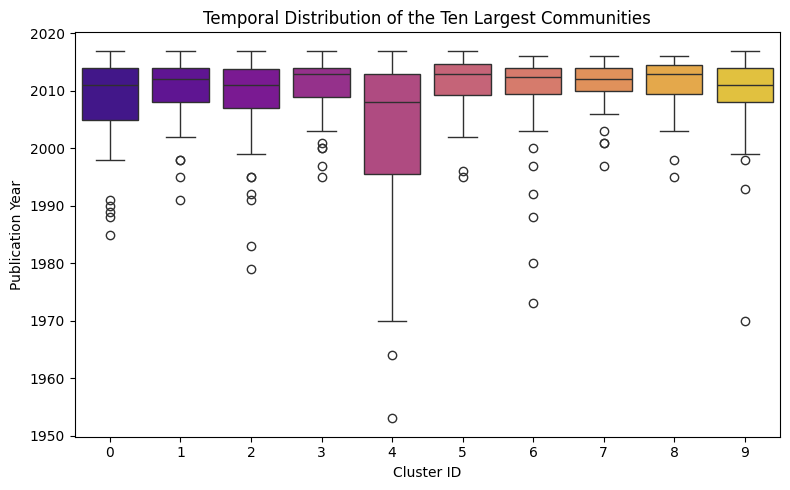

In [8]:

top_clusters = df["cluster_id"].value_counts().head(10).index
subset = df[df["cluster_id"].isin(top_clusters)]

plt.figure(figsize=(8,5))
sns.boxplot(
    data=subset,
    x="cluster_id",
    y="original_publication_year",
    palette="plasma"
)
plt.xlabel("Cluster ID")
plt.ylabel("Publication Year")
plt.title("Temporal Distribution of the Ten Largest Communities")
plt.tight_layout()
plt.savefig(out_dir / "cluster_timeline_boxplot.png", dpi=300)
plt.show()



# Plot Mean Year vs. Language Purity

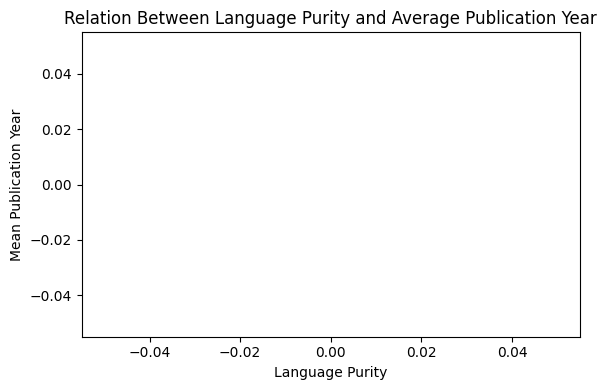

In [9]:
merged = lang_summary.merge(
    year_stats,
    on='cluster_id',
    suffixes=('', '_year')
)
if 'num_works_year' in merged:
    merged = merged.drop(columns=['num_works_year'])

plt.figure(figsize=(6,4))
plt.scatter(merged['language_purity'], merged['mean_year'], s=40, color='black')
plt.xlabel('Language Purity')
plt.ylabel('Mean Publication Year')
plt.title('Relation Between Language Purity and Average Publication Year')
plt.tight_layout()
plt.savefig(out_dir / 'language_vs_year.png', dpi=300)
plt.show()


Series([], Name: proportion, dtype: float64)


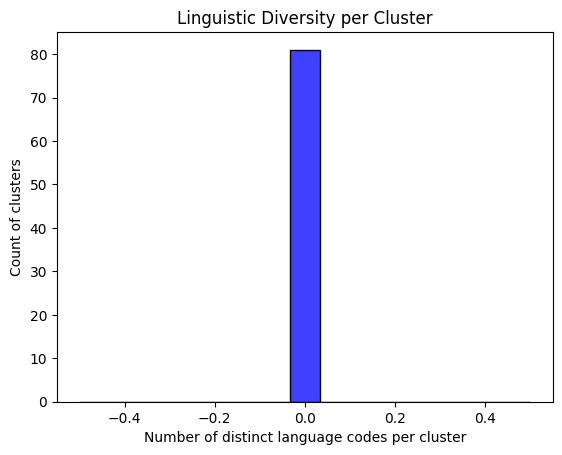

In [10]:
# 1. Estimate reliability of language codes
lang_counts = df[LANGUAGE_FIELD].value_counts(normalize=True, dropna=True)
print(lang_counts.head(10))

# 2. Approximate linguistic diversity per cluster
lang_diversity = (
    df.groupby("cluster_id")[LANGUAGE_FIELD]
      .apply(lambda x: x.dropna().nunique())
      .reset_index(name="num_languages")
)
sns.histplot(data=lang_diversity, x="num_languages", bins=15, color="blue")
plt.xlabel("Number of distinct language codes per cluster")
plt.ylabel("Count of clusters")
plt.title("Linguistic Diversity per Cluster")
plt.show()



🔍 Language Metadata Overview
original_language_id
NaN    810
Name: count, dtype: int64

Top language codes by frequency:
original_language_id
NaN    1.0
Name: count, dtype: float64


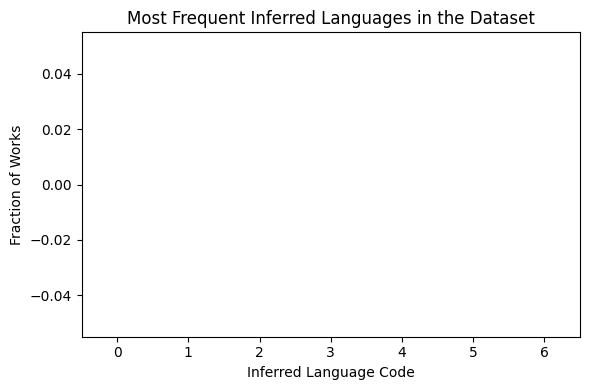

In [10]:
# --------------------------------------------------------------------
# 9. Language Metadata Reliability Diagnostics
# --------------------------------------------------------------------

print("\n🔍 Language Metadata Overview")
lang_counts = df["original_language_id"].value_counts(dropna=False)
print(lang_counts.head(10))

total = lang_counts.sum()
lang_share = (lang_counts / total).round(3)
print("\nTop language codes by frequency:")
print(lang_share.head(10))

plt.figure(figsize=(6,4))
sns.barplot(x=lang_share.head(10).index, y=lang_share.head(10).values, color="gray", edgecolor="black")
plt.ylabel("Fraction of Works")
plt.xlabel("Inferred Language Code")
plt.title("Most Frequent Inferred Languages in the Dataset")
plt.tight_layout()
plt.savefig(out_dir / "language_code_distribution.png", dpi=300)
plt.show()




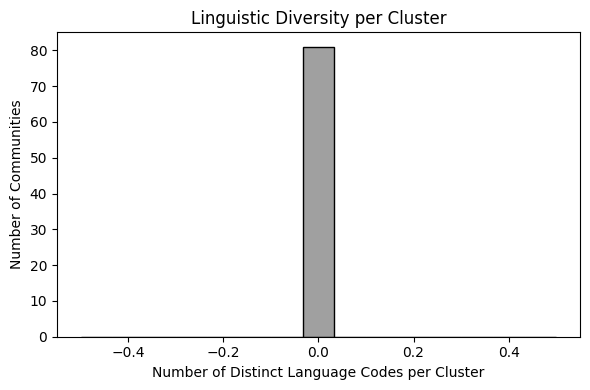

In [11]:
# --------------------------------------------------------------------
# 10. Linguistic Diversity Per Cluster
# --------------------------------------------------------------------

lang_diversity = (
    df.groupby("cluster_id")["original_language_id"]
      .apply(lambda x: x.nunique())
      .reset_index(name="num_languages")
)

plt.figure(figsize=(6,4))
sns.histplot(data=lang_diversity, x="num_languages", bins=15, color="gray", edgecolor="black")
plt.xlabel("Number of Distinct Language Codes per Cluster")
plt.ylabel("Number of Communities")
plt.title("Linguistic Diversity per Cluster")
plt.tight_layout()
plt.savefig(out_dir / "language_diversity_per_cluster.png", dpi=300)
plt.show()

# Save table for reference
lang_diversity.to_csv(out_dir / "language_diversity_per_cluster.csv", index=False)




Estimated fraction of linguistically 'pure' clusters (≥ 80% one language): 0.00%


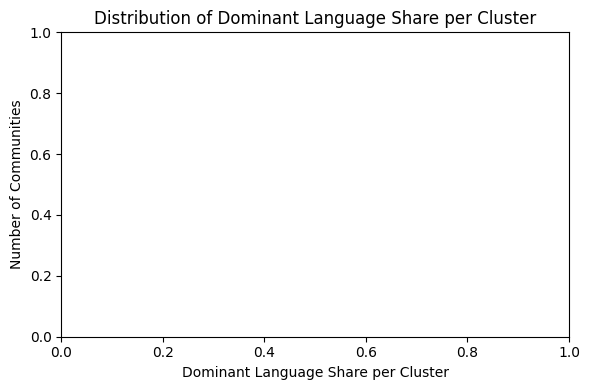

In [12]:
# --------------------------------------------------------------------
# 11. Approximate Reliability Metric
# --------------------------------------------------------------------
# Compute fraction of clusters dominated by a single language code (purity ≥ 0.8)
dominant_langs = df.groupby("cluster_id")["original_language_id"].apply(
    lambda x: x.value_counts(normalize=True).iloc[0] if len(x.value_counts()) > 0 else np.nan
)
reliable_clusters = (dominant_langs >= 0.8).mean()
print(f"\nEstimated fraction of linguistically 'pure' clusters (≥ 80% one language): {reliable_clusters:.2%}")

plt.figure(figsize=(6,4))
sns.histplot(x=dominant_langs.dropna(), bins=15, color="gray", edgecolor="black")
plt.xlabel("Dominant Language Share per Cluster")
plt.ylabel("Number of Communities")
plt.title("Distribution of Dominant Language Share per Cluster")
plt.tight_layout()
plt.savefig(out_dir / "dominant_language_share.png", dpi=300)
plt.show()


# Summary Table

In [13]:
summary_table = merged[['cluster_id','num_works','dominant_language','language_purity','mean_year','year_std']]
print(summary_table.head(10))
summary_table.to_csv(out_dir / 'language_time_summary.csv', index=False)
print(f"\nOutputs saved to {out_dir}")


   cluster_id  num_works  dominant_language  language_purity    mean_year  \
0           0        214                NaN              NaN  2008.743243   
1           1        189                NaN              NaN  2010.228070   
2           2        149                NaN              NaN  2008.043478   
3           3        134                NaN              NaN  2010.553191   
4           4        115                NaN              NaN  2001.542857   
5           5        115                NaN              NaN  2011.368421   
6           6        108                NaN              NaN  2008.500000   
7           7        107                NaN              NaN  2011.032258   
8           8        102                NaN              NaN  2010.903226   
9           9         92                NaN              NaN  2008.878788   

    year_std  
0   7.305582  
1   5.223633  
2   8.674244  
3   5.232875  
4  16.562436  
5   5.174893  
6  10.330261  
7   4.819985  
8   5.312594  
9 